# Chapter 1.5:  One Queue or Two

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import libraries
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

This notebook presents a case study from *Modeling and Simulation in Python*.  It explores a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

This figure shows the three scenarios we'll consider:

<img src="../Images_and_Data/Images/queues.PNG" style="width: 500px;"/>
*One queue, one server (left), one queue, two servers (middle), two
queues, two servers (right).*

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.  Most people take less than 5 minutes, but a few take substantially longer, which is probably not a bad model of the distribution in real stores.

Let's implement the model!

## One server, one queue

### Part 1

Up until now, we have simply entered many of the parameters of our model (`p1`,`p2`,`num_steps`) into our functions when we ran the simulations.  Let's start to put those parameters into a container: we'll use the `dictionary`, the Python object that stores a group of key-value pairs.

Here's a function called `make_system` that takes `lam` and `mu` as parameters and returns a `System` object with variables `lam`, `mu`, and `duration`.  Set `duration`, which is the number of time steps to simulate, to 10 hours, expressed in minutes. 

In [2]:
# Define make_system
def make_system(lam,mu):
    system = dict(lam=lam, mu=mu, duration=600)
    return system

Test this function by creating a `System` object with `lam=1/8` and `mu=1/5`.

In [3]:
# Test function
system = make_system(1/8,1/5)
system

{'lam': 0.125, 'mu': 0.2, 'duration': 600}

### Part 2

Write an change function that takes as parameters `x`, which is the total number of customer in the store, including the one checking out and `system`, which is a `dictionary`.

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.

It should return the total number of customers at the end of the time step.

To use `lam` or `mu` from the `system`, you'll need to call for the value of those keys, using this syntax: `system['mu']` or `system['lam']`.

In [4]:
# Define change function
def change_func(x,system):

    if x > 0:
        if flip(system['mu']):
            x -= 1
            
    # The addition of new custormers happens second.
    # This assumes that a newly arrived customer can not be served in 
    # the minute that s/he arrives.
    if flip(system['lam']):
        x += 1
    return x

Test your function by calling it with `x=1`, `t=0`, and the `System` object you created.  If you run it a few times, you should see different results.

In [5]:
# Test change_function
x = 1
result = change_func(x,system)
result

1

### Part 3

Now we can run the simulation.  Here's a version of `run_simulation` that creates a time `Series` with the total number of customers in the store, including the one checking out.

In [6]:
def run_simulation(system, change_func):
    """Simulate a queueing system.
    
    system: System object
    change_func: function object
    """
    x = 0
    results = pd.Series([],dtype=object)
    results[0] = x
    
    for t in linspace(0, system['duration'],system['duration']+1):
        x = change_func(x,system)
        results[t+1] = x

    return results

Call `run_simulation` with your change function and plot the results.

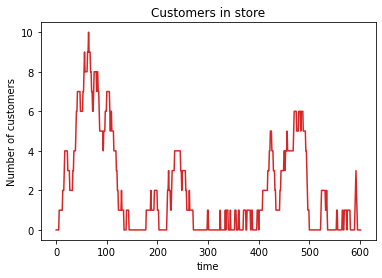

In [7]:
# Plot results
results = run_simulation(system,change_func)
results.plot(label='customers in store',color='C3',
             title='Customers in store',xlabel='time',
             ylabel='Number of customers');

After the simulation, we can compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.  Here's a function that computes them.

In [8]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: Series of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system['lam']
    return L, W

Call `compute_metrics` with the results from your simulation.

In [9]:
# Call compute_metrics
metrics = compute_metrics(results,system)
metrics[0]


2.014950166112957

### Part 4

We want to understand how the store responds to different arrival rates, so we will sweep through possible values for $\lambda$.

If we sweep through values for $\lambda$ (the arrival rate), we want to consider only values that are realistic. Consider, for example, that if customers arrive faster than the completion rate (that is, $\lambda > \mu$), the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open, and the result isn't very interesting.  Likewise, if $\lambda$ is much less than $\mu$, the store essentially stays empty: again, not very interesting.

So we want values that are a significant fraction of $\mu$.   To keep our model as general as we can (to allow for changes in $\mu$, let's sweep through a range of possibilities defined by $\mu$.  Set the simulation to sweep through $\lambda$ values that range from 10% to 80% of the completion rate, $\mu$.  

First, create an array of values for `lam`.

In [10]:
# Create values for lam
mu = 1/5
lam_array = linspace(0.1*mu,0.8*mu,15)


Write a function that takes an array of values for `lam`, a single value for `mu`, and an change function.

For each value of `lam`, it should run a simulation, compute `L` and `W`, and store the value of `W` in a sweep `Series`.

It should return the sweep `Series`.

In [11]:
# Define sweeping function
def sweep_func(lam,mu,change_func):
    sweep = pd.Series([],dtype=object)
    for lam1 in lam_array:
        system['lam'] = lam1
        results = run_simulation(system,change_func)
        metrics = compute_metrics(results,system)
        sweep[lam1] = metrics[1]
    return sweep
        

Call your function to generate a sweep `Series`, and plot it.  Note: depending on how many alpha values you are sweeping through, this might take a couple minutes.  You can tell that a calculation is in process by noting the hourglass icon in the browser tab for this notebook.

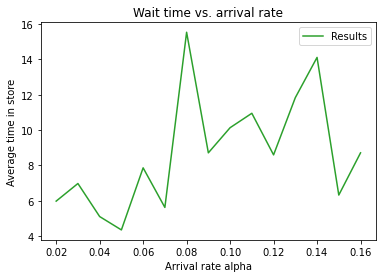

In [12]:
# Generate solution and plot
sweep_results = sweep_func(lam_array,mu,change_func)

sweep_results.plot(label='Results',color='C2',legend=True,
                   title='Wait time vs. arrival rate',
                   xlabel='Arrival rate alpha',
                   ylabel='Average time in store');

If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

In [13]:
# Find the average wait time W for this queuing strategy
sweep_results.mean()

8.719906078294782

### Part 5 (Analysis)

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.

In particular, we can derive the average time in the store as a function of $\mu$ and $\lambda$:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

In [16]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W_array = 1 / (mu - lam_array)
    # Transform this array into a pd.Series
    W_series = pd.Series(data=W_array, index=lam_array)
    W_series.plot(style='-', label='analysis',legend=True)

Use this function to plot the theoretical results, then plot your simulation results again on the same graph.  How do they compare?

In [1]:
# Compare simulation to theoretical results on a plot
plot_W(lam_array,mu)
sweep_results.plot(label="simulation", 
                   title='Comparison of theoretical and simulation results',
                   xlabel='Arrival rate alpha',ylabel='Average Time in store',
                  legend=True);

NameError: name 'plot_W' is not defined

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

<img src="../Images_and_Data/Images/queues.PNG" style="width: 500px;"/>

### Part 6 (One queue, two servers)

Write an change function for one queue with two servers.

In [ ]:
# Define the new change function
def change_1q_2s(x,system):
    
    if x > 0:
        if flip(system['mu']):
            x -= 1
    if x > 0:
        if flip(system['mu']):
            x -= 1
    # The addition of new custormers happens second.
    # This assumes that a newly arrived customer can not be served in 
    # the minute that s/he arrives.
    if flip(system['lam']):
        x += 1
        
    return x

Use this change function to simulate the system, plot the results, and print the metrics.

In [ ]:
# Simulate, plot results, and print metrics
lam = 1/8
mu = 1/5
system_1q_2s = make_system(lam,mu)

results_1q_2s = run_simulation(system_1q_2s,change_1q_2s)
results_1q_2s.plot(label='customers in store',color='C3',
                   title='Customers in store',xlabel='time',
                   ylabel='Number of customers',legend=True)

metrics = compute_metrics(results_1q_2s,system)
print('The average number of customers in the store is',metrics[0],
      '.  The average wait time is', metrics[1])

Since we have two checkout counters now, we can consider values for $\lambda$ that exceed $\mu$.

Create a new array of values for `lam` from 10% to 160% of `mu`.

In [ ]:
# Create new array
lam_array_1q_2s = linspace(0.1*mu,1.6*mu,29)

Use your sweep function to simulate the two server, one queue scenario with a range of values for `lam`.

Plot the results and print the average value of `W` across all values of `lam`.

In [ ]:
# Generate solution and plot
sweep_results_1q_2s = sweep_func(lam_array_1q_2s,mu,change_1q_2s)

sweep_results_1q_2s.plot(label='Results',color='C2',
                         title='Wait time vs. arrival rate',
                         xlabel='Arrival rate alpha',
                         ylabel='Average time in store',
                        legend=True);

In [ ]:
# Find mean value of wait time
sweep_results_1q_2s.mean()

### Part 7 (Two queues, two servers)

To simulate the scenario with two separate queues, we need two state variables to keep track of customers in each queue.

Write an change function that takes `x1`, `x2`, and `system` as parameters and returns `x1` and `x2` as return values.  If you are not sure how to return more than one return value, see `compute_metrics`.

You want to keep track of the customers separately, which means you need to consider which queue a customer will join when s/he arrives.

In [ ]:
# Create an change function for 2 queues
def change_2q_2s(x1,x2,system):
 
    if x1 > 0:
        if flip(system['mu']):
            x1 -= 1
    if x2 > 0:
        if flip(system['mu']):
            x2 -= 1
            
    # The following assumes that the arriving customer will 
    # join the shortest line
    if flip(system['lam']):
        if x1 > x2:
            x2 += 1
        else:
            x1 += 1

    
    return x1, x2

Write a version of `run_simulation` that works with this change function.

In [ ]:
# Define new run_simulation
def run_simulation_2q_2s(system, change_func):
    """Simulates a queueing system with 2 queues.
    
    system: System object
    change_func: function object
    """
    x1 = 0
    x2 = 0
    results = pd.Series([],dtype=object)
    results[0] = x1 + x2
    
    for t in linspace(0, system['duration'],system['duration']+1):
        x1,x2 = change_func(x1,x2,system)
        results[t+1] = x1 + x2
    return results

Test your functions by running a simulation with a single value of `lam`.

In [ ]:
# Simulate, plot results, and print metrics
lam = 1/8
mu = 1/5
system_2q_2s = make_system(lam,mu)

results_2q_2s = run_simulation_2q_2s(system,change_2q_2s)

results_2q_2s.plot(label='customers in store',color='C3',
                   title='Customers in store',xlabel='time',
                   ylabel='Number of customers',
                  legend=True);

metrics = compute_metrics(results_2q_2s,system_2q_2s)
print('The average number of customers in the store is',metrics[0],
      '.  The average wait time is', metrics[1])

Sweep a range of values for `lam`, plot the results, and print the average wait time across all values of `lam`.

How do the results compare to the scenario with one queue and two servers?

In [ ]:
# Create new array
lam_array_2q_2s = linspace(0.1*mu,1.6*mu,29)

# Define new sweeping function
def sweep_func_2q_2s(lam,mu,change_func):
    sweep = pd.Series([],dtype=object)
    for lam1 in lam_array:
        system['lam'] = lam1
        results = run_simulation_2q_2s(system,change_func)
        metrics = compute_metrics(results,system)
        sweep[lam1] = metrics[1]
    return sweep

# Generate solution and plot
sweep_results_2q_2s = sweep_func_2q_2s(lam_array_2q_2s,mu,change_2q_2s)

sweep_results_2q_2s.plot(label='2 queue Results',color='C2',
                         title='Wait time vs. arrival rate',
                         xlabel='Arrival rate alpha',
                         ylabel='Average time in store',
                        legend=True);


In [ ]:
print('The average wait time across arrival rates for the 1 queue/ 2 server model is',
      sweep_results_1q_2s.mean(),
     'The average wait time for the 2 queue/ 2 server model is ',
      sweep_results_2q_2s.mean())